<a href="https://colab.research.google.com/github/Tobsige/LoadPrediction/blob/main/LF_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
import seaborn as sns
from google.colab import files
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ausdata1.CSV to ausdata1.CSV
User uploaded file "ausdata1.CSV" with length 4346740 bytes


In [ ]:
column_names = ['Date', 'Hour', 'DryBulb', 'DewPnt', 'WetBulb', 'Humidity', 'ElecPrice', 'SYSLoad']
dataframe = pd.read_csv('ausdata1.CSV', names = column_names, usecols=['SYSLoad'], skiprows=1)

dataset = dataframe.values #numpy.ndarray
dataset = dataset.astype('float32')

dataset.shape

(87648, 1)

In [ ]:
numpy.random.seed(7)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

61353 26295


In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX.shape

(61322, 30)

In [ ]:
trainY.shape

(1, 61322)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

from keras.callbacks import EarlyStopping
import time

# create and fit the LSTM network
model = Sequential() # New Instance of Model Object
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

start = time.time()
hist =model.fit(trainX, trainY, epochs=150, shuffle=True,batch_size=125, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=30)], verbose=1)

end = time.time()
# Training Phase
model.summary()

Epoch 1/150
491/491 [==============================] - 4s 5ms/step - loss: 0.0193 - val_loss: 4.5230e-04
Epoch 2/150
491/491 [==============================] - 2s 3ms/step - loss: 4.1531e-04 - val_loss: 3.1762e-04
Epoch 3/150
491/491 [==============================] - 2s 4ms/step - loss: 2.8668e-04 - val_loss: 2.1031e-04
Epoch 4/150
491/491 [==============================] - 2s 4ms/step - loss: 2.3414e-04 - val_loss: 1.6640e-04
Epoch 5/150
491/491 [==============================] - 2s 4ms/step - loss: 1.8873e-04 - val_loss: 1.8782e-04
Epoch 6/150
491/491 [==============================] - 2s 3ms/step - loss: 1.7910e-04 - val_loss: 2.3284e-04
Epoch 7/150
491/491 [==============================] - 2s 3ms/step - loss: 1.7261e-04 - val_loss: 1.3866e-04
Epoch 8/150
491/491 [==============================] - 2s 3ms/step - loss: 1.5942e-04 - val_loss: 1.3507e-04
Epoch 9/150
491/491 [==============================] - 2s 3ms/step - loss: 1.5283e-04 - val_loss: 1.7158e-04
Epoch 10/150
491/491 [=

In [ ]:
print ("Model took %0.2f seconds to train"%(end - start))

Model took 254.49 seconds to train


In [ ]:
logger=keras.callbacks.TensorBoard(log_dir='logs', write_graph=True)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

from sklearn.metrics import mean_absolute_error

print('Mean Absolute Error Test:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Mean Squared Error Test:',np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(testY[0], testPredict[:,0]))

print('Mean Absolute Error Train:', mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Mean Squared Error Train:',np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(trainY[0], trainPredict[:,0]))


print('Mean Absolute Error Test:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Mean Squared Error Test:',np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(testY[0], testPredict[:,0]))

Mean Absolute Error Test: 77380958.99320655
Mean Squared Error Test: 78313732.26680803
Mean Absolute Error Train: 687510449580.2091
Mean Squared Error Train: 696185871963.503
Mean Absolute Error Test: 77380958.99320655
Mean Squared Error Test: 78313732.26680803


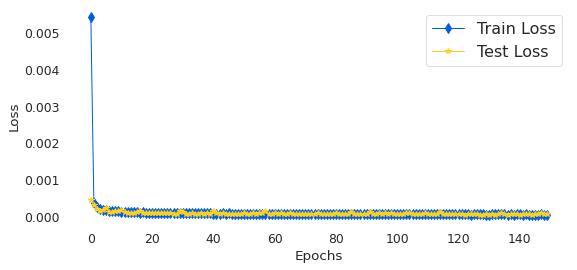

In [ ]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.4)  
plt.figure(figsize=(9,4))
import matplotlib as mpl
#mpl.rcParams['legend.frameon'] = 'True'
plt.plot(hist.history['loss'], color='#005ce6', linewidth=1, marker='d', markersize=7, label='Train Loss')
plt.plot(hist.history['val_loss'], color='#ffd11a',linewidth=1, marker='*',markersize=6, label='Test Loss')
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.box(False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend(loc='upper right',prop={'size': 16})
#legend.get_frame().set_facecolor('#8c8c8c')